this code is dedicated to model based reinforcement learning with [Neural Ordinary Differential equations](https://github.com/rtqichen/torchdiffeq) as a function approximator for the dynamics model. the code is accomodated for addition of control actions in a forked repo. the envs and mpc controller is taken from [pytorch mpc](https://github.com/locuslab/mpc.pytorch/)

## imports

In [0]:
!pip install mpc
!pip install noise
!pip install torch==1.4 torchvision==0.4.1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  


In [0]:
!git clone https://github.com/karim174/torchdiffeq.git

In [0]:
!cd torchdiffeq && pip install -e .

In [0]:
import logging
import math
import time
import noise
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F


from mpc import mpc
from mpc import util
from mpc.mpc import QuadCost, LinDx, GradMethods
from mpc.env_dx import pendulum, cartpole


%matplotlib inline
import os 
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

import random
import tempfile
import time
from tqdm import tqdm

from torchdiffeq.torchdiffeq import odeint_adjoint as odeint


use_cuda = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Create a custom logger
base_file = '/content/drive/My Drive/CNODE-VAE/experiments/exp1'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(base_file+"training_hist.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('logger')


In [0]:

TRAIN_EPOCH = 15#100 #150

TIMESTEPS = 10  # T
LQR_ITER = 50
ACTION_LOW = -2.0
ACTION_HIGH = 2.0
SPEED_LOW = -8.0
SPEED_HIGH = 8.0

nx = 3 #changed to 2 theta and dtheta instead of sins and cosines
nu = 1

## Network

In [0]:

class code(nn.Module):

    def __init__(self, feature_dim=3, activation = nn.Tanh(), hidden_dim = 64, ctrl_dim=1):
        super(code, self).__init__()


        self.net = nn.Sequential(
            nn.Linear(feature_dim+ctrl_dim, hidden_dim),
            activation, 
            nn.Linear(hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),   
            nn.Linear(hidden_dim, hidden_dim),
            activation,  
            nn.Linear(hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, feature_dim)
        )
        self.ctrl_dim = ctrl_dim
        if ctrl_dim:
          self.control_sequences = lambda x: torch.zeros(ctrl_dim)
  
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
              if activation == nn.Tanh() :
                nn.init.xavier_uniform_(m.weight, gain=1.0)
              else:nn.init.normal_(m.weight, mean=0, std=np.sqrt(2/m.in_features))
              nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
      
      if self.ctrl_dim:
        with torch.no_grad():  
            
          if t.is_cuda:  
            t_c = t.cpu()
            c = self.control_sequences(t_c.clone().detach().numpy())
           
          
          else:
            c = self.control_sequences(t.clone().detach().numpy())
          
          if not torch.is_tensor(c):
            c = torch.from_numpy(c)
            
          
          if len(c.shape) == 1:
            c = torch.ones_like(y[:, 0][..., None]) * c #replaced from zeros
          
          c =c.to(t)
          if t.requires_grad:
            c.requires_grad_()
        y_cat=torch.cat([y,c], axis = 1)
        return self.net(y_cat)
      return self.net(y)


## Utility


In [0]:
def get_batch_with_ctrl(XU):
    s = torch.from_numpy(np.random.choice(np.arange(XU.shape[0] - batch_time, dtype=np.int64), batch_size, replace=True))
    ep = torch.from_numpy(np.random.choice(XU.shape[1], batch_size, replace=True))
    batch_y0 = XU[s,ep,:nx]  # (M, D)
    t = torch.linspace(0., T*dt, T)  
    batch_t = t[:batch_time]  # (T)
    batch_u = torch.stack([XU[s + i, ep, nx:] for i in range(batch_time)], dim=0)  # (T, M, D)
    batch_y = torch.stack([XU[s + i, ep, :nx] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, batch_u

In [0]:

def tuning():
  n_ep = random.choice([2500, 3000, 4000, 5000])
  batch_size = random.choice([32, 64, 128, 256, 512]) 
  T = random.choice([250, 500, 750])
  batch_time = random.choice([16, 32, 64, 128]) 
  optimizer = random.choice(['RMSprop', 'Adam', 'AdamW'])
  activation = random.choice([nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Tanh()])
  hidden_dim = random.choice([32, 64, 128])
  steps_per_epoch = (n_ep * T) / (batch_time*batch_size) #ADDED (KARIM) *batch_size
  control_option = random.choice(['single act diff scale', 'diff all'])
  Act_per_batch = random.choice([5, 10])
  # nets = ['net1', 'net2']
  return [n_ep, batch_size, T, batch_time, 
          activation, hidden_dim, optimizer, steps_per_epoch, 
          control_option, Act_per_batch]


In [0]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [0]:
def to_np(x):
    if type(x) is np.ndarray:
      return x
    #print(type(x))
    return x.detach().cpu().numpy()

def angle_normalize(x):
    return (((x + np.pi) % (2 * np.pi)) - np.pi)

def save_checkpoint(state, filename=base_file+'/checkpoint6.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    
    torch.save(state, filename)  # save checkpoint



In [0]:

class normalizer():
  
  def __init__(self, orig_scale, target_scale):
    self.orig_scale = orig_scale
    self.tar_scale = target_scale
  
  def normalize(self, x):
    if  torch.is_tensor(self.orig_scale) and torch.is_tensor(self.tar_scale):
      self.orig_scale = self.orig_scale.to(x)
      self.tar_scale = self.tar_scale.to(x)
    ft_min = self.orig_scale[0]
    ft_max = self.orig_scale[1]
    rng = (self.tar_scale[1]-self.tar_scale[0])
    tar_min = self.tar_scale[0]
    x_norm = rng*(x-ft_min)/(ft_max-ft_min)+tar_min
    return x_norm
  
  def denorm(self, x):
    if  torch.is_tensor(self.orig_scale) and torch.is_tensor(self.tar_scale):
      self.orig_scale = self.orig_scale.to(x)
      self.tar_scale = self.tar_scale.to(x)
    ft_min = self.tar_scale[0]
    ft_max = self.tar_scale[1]
    rng = (self.orig_scale[1]-self.orig_scale[0])
    tar_min = self.orig_scale[0]

    x_norm = rng*(x-ft_min)/(ft_max-ft_min)+tar_min
    return x_norm



In [0]:
def add_line(legend):
    from matplotlib.lines import Line2D
    ax = legend.axes
    #cmap = plt.cm.binary
    custom_line = Line2D([0], [0], color='k', lw=2, linestyle = '--', label = 'predicted')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(custom_line)
    labels.append("predicted")
    ax.legend(handles=handles, labels=labels)

def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8), freq = 1):
    #print(obs[0].shape, times[0].shape, trajs[0].shape )
    fig, ax = plt.subplots(freq, 1, figsize = (figsize[0], freq*figsize[1]))  # Create a figure and an axes.
    ax = ax if (type(ax) is tuple) or isinstance(ax, np.ndarray)  else (ax,)

    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            freq_o = min(freq, o.shape[1] )
            for b_i in range(freq):
                ax[b_i].plot(t, o[:,b_i, 0], 'g-', label='costheta') # Plot some data on the axes.
                ax[b_i].plot(t, o[:,b_i, 1], 'b-', label='sintheta')  # Plot some data on the axes.
                ax[b_i].plot(t, o[:,b_i, 2], 'r-', label='omega')  # Plot some data on the axes.
                ax[b_i].set_xlabel('time')  # Add an x-label to the axes.
                ax[b_i].set_ylabel('states')  # Add a y-label to the axes.
                ax[b_i].set_title("Progression of states with time")  # Add a title to the axes.
                ax[b_i].legend()  # Add a legend.
                #plt.plot(t, o[:,b_i, 0], 'g-', t, o[:, b_i, 1], 'b-', t, o[:, b_i, 2], 'r-')
             
                

    if trajs is not None: 
        for z, t in zip(trajs, times):
            z = to_np(z)
            freq_o = min(freq, z.shape[1] )
            
            for b_i in range(freq):
              ax[b_i].plot(t, z[:,b_i, 0], 'g--');  # Plot some data on the axes.
              ax[b_i].plot(t, z[:,b_i, 1], 'b--');  # Plot some data on the axes.
              ax[b_i].plot(t, z[:,b_i, 2], 'r--');  # Plot some data on the axes.
              add_line(ax[b_i].legend())
              #ax[b_i].legend(handlelength=3)  # Add a legend.
              #plt.plot(t, z[:, b_i, 0], 'g--', t, z[:, b_i, 1], 'b--', t, z[:, b_i, 2], 'r--')
              #plt.set_xlabel('time')  # Add an x-label to the axes.
              #plt.set_ylabel('states')  # Add a y-label to the axes.
              #plt.set_title("Progression of states with time")  # Add a title to the axes.
              #plt.legend()  # Add a legend.

        if save is not None:
            plt.savefig(save)
    plt.show()

In [0]:
def control_action(T, batch_size, ctrl_dim, boundary_scale, option = {'single act diff scale'}, act_per_batch = None):
  #the SU_MS corresponds to having the same action but with different scales 
  # the su corresponds to single control action for all 
  act_per_batch = batch_size if act_per_batch is None else act_per_batch
  world = np.zeros((batch_size,T))
  #scales_order = np.arange(0,2,1,  dtype=float)[np.newaxis, ...]
  #scales_mag = np.arange(0.1,1, 0.1, dtype=float)[..., np.newaxis]
  #scales = (10**(scales_order)*scales_mag).flatten()
  scales = np.concatenate([np.arange(2,30, 1, dtype=float), np.arange(30,150, 3, dtype=float), np.arange(150,400, 20, dtype=float)]) #1,80
  #print(scales)
  #scales = np.arange(-20,100,5) 
  
  if option == 'single act diff scale':
    
    for b in range(act_per_batch):
      scale = np.random.choice(scales)
      octaves = np.random.choice(2)+1
      lacunarcity = np.random.choice(2)+1
      for t in range(T):
        world[b,t] = noise.pnoise1(t/scale, octaves=octaves, persistence=0.5, lacunarity=lacunarcity, repeat=T, base=0) #2


  elif option == 'diff all':
    # this should be tested
    for g in range(batch_size//act_per_batch):
      scale = np.random.choice(scales)
      octaves = np.random.choice(2)+1
      lacunarcity = np.random.choice(2)+1
      for t in range(T*act_per_batch):
        #print(g*(act_per_batch),  + t//T)
        world[g*(act_per_batch) + t//T, t%T] = noise.pnoise1(t/scale, octaves=octaves, persistence=0.5, lacunarity=lacunarcity, base=0)

  # add boundries to the world instead of action from -1 to 1 
  max_perep = np.amax(world,axis=-1)[..., np.newaxis]
  min_perep = np.amin(world, axis = -1)[..., np.newaxis]
  #print(np.unique(max_perep), np.unique(min_perep))
  world = 2*boundary_scale*(world-min_perep)/(max_perep-min_perep)-boundary_scale

  return world

In [0]:
def validate_model(func, T):
  #given the ode function validate it on new data
  val_bs = 600
  u = np.zeros((val_bs,T))
  scales = np.arange(2, 20, 0.5)

  for b in range(val_bs):
    scale = np.random.choice(scales)
    for t in range(T, 2*T):
      u[b,t-T] = noise.pnoise1(t/scale, octaves=2, persistence=0.5, lacunarity=2.0, repeat=2*T, base=0)
  true_u = u.T
  time_t = np.arange(T)
  #plt.plot(time_t , true_u[:,20])
  # bootstrap network with random actions
  params = torch.tensor((10., 1., 1.))
  dx = pendulum.PendulumDx(params, simple=True)

  states_ds = []
  ctrl_ds = []
  x_init = reset_env(val_bs).double()
  tensor_true_u = torch.from_numpy(true_u).double()
  for t in tqdm(range(T)):
      x = dx(x_init, tensor_true_u[t].view(-1,1))
      states_ds.append(x_init)
      action = torch.clamp(tensor_true_u[t], ACTION_LOW, ACTION_HIGH)
      x[...,-1] = torch.clamp(x[...,-1], SPEED_LOW, SPEED_HIGH)
      ctrl_ds.append(action)
      x_init = x
  states_ds = torch.stack(states_ds)
  ctrl_ds = torch.stack(ctrl_ds).view(T,val_bs,1)
  val_data = torch.cat((states_ds, ctrl_ds), dim = -1)
  val_data = norm.normalize(val_data)
  with torch.no_grad():
    y_tot = val_data[:T//4, :, :nx].cuda()
    y0_tot = val_data[0, :, :nx].cuda()
    c_tot = val_data[:T//4, :, nx:].cuda()
    t_tot = torch.linspace(0., T*dt//4, T//4).to(c_tot).cuda()
    func = func.double().cuda()
    pred_y_t = odeint(func, y0_tot.double(), t_tot.double(), c_tot.double(), method = 'euler')
    qq = to_np(pred_y_t)
    loss_all = torch.mean(torch.sqrt(((pred_y_t - y_tot)/2)**2))
    loss_part = torch.mean(torch.sqrt(((pred_y_t[:10] - y_tot[:10])/2)**2))
    plot_trajectories([to_np(y_tot[:10])], [to_np(t_tot[:10])], [to_np(pred_y_t[:10])])
    plot_trajectories([to_np(y_tot)], [to_np(t_tot)], [to_np(pred_y_t)])
    #plot_trajectories([to_np(y_tot[:10])], [to_np(t_tot[:10])], [to_np(pred_y_t[:10])])
    print('Total Loss {:.6f}, {:.6f}'.format(loss_all, loss_part))
    



In [0]:
#sep test

def uniform(shape, low, high):
    r = high-low
    
    return torch.rand(shape)*r+low

def reset_env(n_env = 1,Low = torch.tensor([-np.pi, -2.5]), High = torch.tensor([np.pi, 2.5])):

    state = uniform((n_env, nx-1), Low, High)
    return torch.stack((torch.cos(state[:,0]), torch.sin(state[:,0]), state[:,1]), dim=-1)
    


## setting up hyperparameters and getting control

In [0]:
dataset = None
normalized = True
mse = True
add_aux = True

if mse and normalized:
  loss_f = lambda pred_y, batch_y: torch.mean((pred_y - batch_y)**2)
  logger.info(f'Loss type: mse, ')

elif not mse and normalized:
  loss_f = lambda pred_y, batch_y: torch.mean(torch.abs(pred_y - batch_y))
  logger.info(f'Loss type: not mse, ')

elif mse and not normalized:
  loss_f = lambda pred_y, batch_y: torch.mean(((pred_y - batch_y)*torch.tensor([8, 8, 1]).cuda())**2)
  logger.info(f'Loss type: mse, ')

else:
  loss_f = lambda pred_y, batch_y: torch.mean(torch.abs(pred_y - batch_y)*torch.tensor([8, 8, 1]).cuda())
  logger.info(f'Loss type: not mse, ')
  

logger.info(f'add_aux: {add_aux}, normalized:, {normalized} \n')



In [0]:
single_u  = False
n_episodes, batch_size, T, batch_time, activation, hidden_dim, optim, steps_per_epoch, control_option, act_per_batch = tuning()
logger.info(f'n_episodes {n_episodes} batch_size {batch_size} T {T} batch_time {batch_time} activation {activation} hidden_dim {hidden_dim} optim {optim} steps_per_epoch {steps_per_epoch} control_option {control_option} act_per_batch {act_per_batch}')
logger.info('\n')
dt = 0.05
T = 500
batch_size = 512
batch_time = 20 #16
n_episodes = 40000 #3000 #remove
hidden_dim = 32
activation = nn.Tanh()
optim = 'adamW'
control_option = 'diff all'
act_per_batch = 200
steps_per_epoch = n_episodes*T//(batch_size*batch_time)
t = torch.linspace(0., T*dt, T)  
print( 'n_episodes', n_episodes,'batch_size' , batch_size,'T' , T, 'batch_time' , batch_time, 'activation' , activation, 'hidden_dim' , hidden_dim, 
            'optim', optim, 'steps_per_epoch', steps_per_epoch, 'control_option', control_option, 'act_per_batch', act_per_batch)

## Training

In [0]:
class true_dynamics(torch.nn.Module):
      def forward(self, state, action):
          cos_th = state[:, 0].view(-1, 1)
          sin_th = state[:, 1].view(-1, 1)
          thdot = state[:, 2].view(-1, 1)
          th = torch.atan2(sin_th, cos_th)

          g = 10
          m = 1
          l = 1
          dt = 0.05

          u = action
          u = torch.clamp(u, -2, 2)

          newthdot = thdot + (-3 * g / (2 * l) * -(sin_th) + 3. / (m * l ** 2) * u) * dt
          newth = th + newthdot * dt
          newthdot = torch.clamp(newthdot, -8, 8)

          state = torch.cat((torch.cos(newth),torch.sin(newth), newthdot), dim=1)
          return state

In [0]:
true_u = control_action(T, n_episodes, 1, 2, option = control_option, act_per_batch=act_per_batch)

true_u=true_u.T
true_dyn = true_dynamics()

In [0]:
from tqdm import tqdm

params = torch.tensor((10., 1., 1.))
dx = pendulum.PendulumDx(params, simple=True)

states_ds = []
ctrl_ds = []
x_init = reset_env(n_episodes).double()
tensor_true_u = torch.from_numpy(true_u).double()

for t in tqdm(range(T)):
    #print(x_int.shape, true_u.shape)
    
    x = dx(x_init, tensor_true_u[t].view(-1,1))
    states_ds.append(x_init)
    action = torch.clamp(tensor_true_u[t], ACTION_LOW, ACTION_HIGH)
    x[...,-1] = torch.clamp(x[...,-1], SPEED_LOW, SPEED_HIGH)
    ctrl_ds.append(action)
    x_init = x
states_ds = torch.stack(states_ds)
ctrl_ds = torch.stack(ctrl_ds).view(T,n_episodes,1)
print(states_ds.shape, ctrl_ds.shape)
new_data = torch.cat((states_ds, ctrl_ds), dim = -1)

In [0]:
u_init = None
render = True
run_iter = 500
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

ft_high = np.array([1, 1, SPEED_HIGH, ACTION_HIGH])

ft_low  = ft_high*-1
norm=normalizer([ft_low, ft_high], [-1,1])

In [0]:
def train(new_data, activation, hidden_dim, optim, steps_per_epoch, norm, old_dataset= True, save_data=False):
    global dataset
    global func #added

    if not torch.is_tensor(new_data):
        new_data = torch.from_numpy(new_data)
        # print(new_data.shape,'2')

    # preprocess data
    # clamp actions
    new_data[:,:, -1] = torch.clamp(new_data[:,:, -1], -ACTION_HIGH, ACTION_HIGH)
    new_data = norm.normalize(new_data)


    # append data to whole dataset
    if dataset is None:
        dataset = new_data
        

  
    else:
      if old_dataset==False:
        dataset= new_data
      else:
        dataset = torch.cat((dataset, new_data), dim=0)


    if save_data==True:
      dataset_df=pd.DataFrame(dataset, columns = ['Time_steps,episodes,states&actions']) 
      dataset_df.to_csv(base_file+'dataset.csv', index = False) #saved in video folder



    # train on the whole dataset (assume small enough we can train on all together)
    XU = new_data.detach()

    if use_cuda:
      # func = net(activation = activation, hidden_dim = hidden_dim, ctrl_dim=1)
      func = func.cuda()

    if optim == 'RMSprop':
      #play with the values of mommentum and weight decay
      optimizer = torch.optim.RMSprop(func.parameters(), lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    elif optim == 'Adam':
      #play with the values of mommentum and weight decay
      optimizer = torch.optim.Adam(func.parameters(), betas=(0.9, 0.999), lr=3e-3) 

    else:
      #play with the values of mommentum and weight decay
      optimizer = torch.optim.AdamW(func.parameters(), lr=0.001)

    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)

    for epoch in range(TRAIN_EPOCH):
        for i in range(int(steps_per_epoch)):
          
          optimizer.zero_grad()

          batch_y0, batch_t, batch_y, batch_u = get_batch_with_ctrl(XU)
          
          if use_cuda:
              batch_y0, batch_t, batch_y, batch_u = batch_y0.cuda(), batch_t.cuda(), batch_y.cuda(), batch_u.cuda()
          
          pred_y = odeint(func, batch_y0.float(), batch_t.float(), batch_u.float(), method = 'euler')
          
          loss = loss_f(pred_y, batch_y)

          if add_aux:
            loss_aux = 0.001* torch.mean(torch.abs(pred_y[:,:,0]**2 + pred_y[:,:,1]**2 -1))
            loss = loss+loss_aux

          loss.backward()
          optimizer.step()
          logger.info("iter %d epoch %d loss %f \n", i, epoch, loss.mean().item())
          #logger.info('\n')
          
          print("iter: ",i, "epoch: ", epoch, "loss: ", loss.mean().item())
        save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': func.state_dict(),
        })
        
        with torch.no_grad():
            time_horizon = 64
            y_tot = XU[:time_horizon, :, :nx].cuda()
            y0_tot = XU[0, :, :nx].cuda()
            c_tot = XU[:time_horizon, :, nx:].cuda()
            t_tot = torch.linspace(0., time_horizon*dt, time_horizon).to(c_tot)
            pred_y_t = odeint(func, y0_tot.float(), t_tot.float(), c_tot.float(), method = 'euler')
            loss_all = torch.mean(torch.abs(pred_y_t - y_tot))
            print('Iter {:04d} | Total Loss {:.6f}'.format(epoch, loss_all))
            plot_trajectories([to_np(batch_y)], [to_np(batch_t)], [to_np(pred_y)])
            plot_trajectories([to_np(y_tot)], [to_np(t_tot)], [to_np(pred_y_t)])
          
       


In [0]:
dataset = None
func = code(activation = activation, hidden_dim = hidden_dim, ctrl_dim=1)

In [0]:
TRAIN_EPOCH = 18
train(new_data, activation, hidden_dim, optim, steps_per_epoch, norm) #boot_strap ==0 init state data
logger.info("bootstrapping finished")

## Loading and validating model

In [0]:
from collections import OrderedDict
if use_cuda:
    checkpoint = torch.load('/content/drive/My Drive/checkpoint6.pth.tar')
else:
    # Load GPU model on CPU
    checkpoint = torch.load('/content/drive/My Drive/checkpoint6.pth.tar',
                            map_location=lambda storage,
                            loc: storage)
start_epoch = checkpoint['epoch']
weights = OrderedDict( (key.replace('net.', ''), value) for key, value in checkpoint['state_dict'].items())
func = code(activation = activation, hidden_dim = hidden_dim, ctrl_dim=1)
func.net.load_state_dict(weights)
#print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))

<All keys matched successfully>

100%|██████████| 500/500 [00:00<00:00, 3153.78it/s]


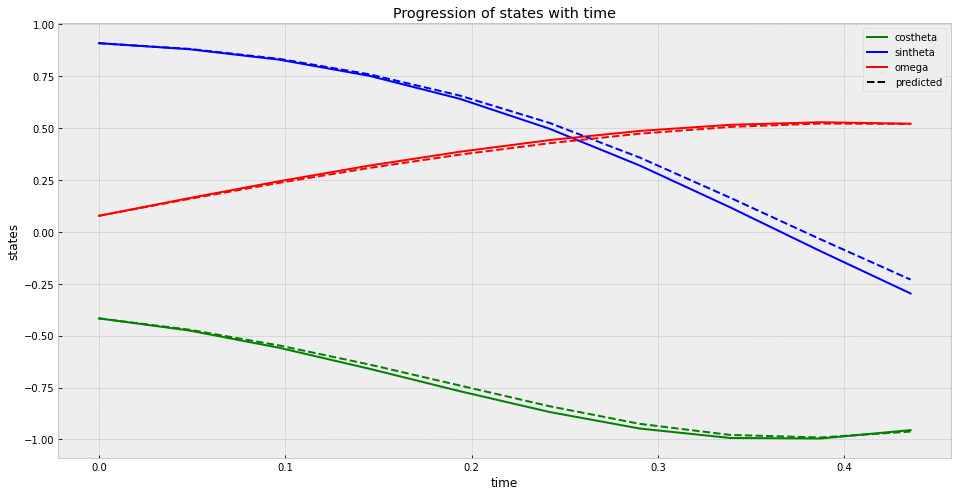

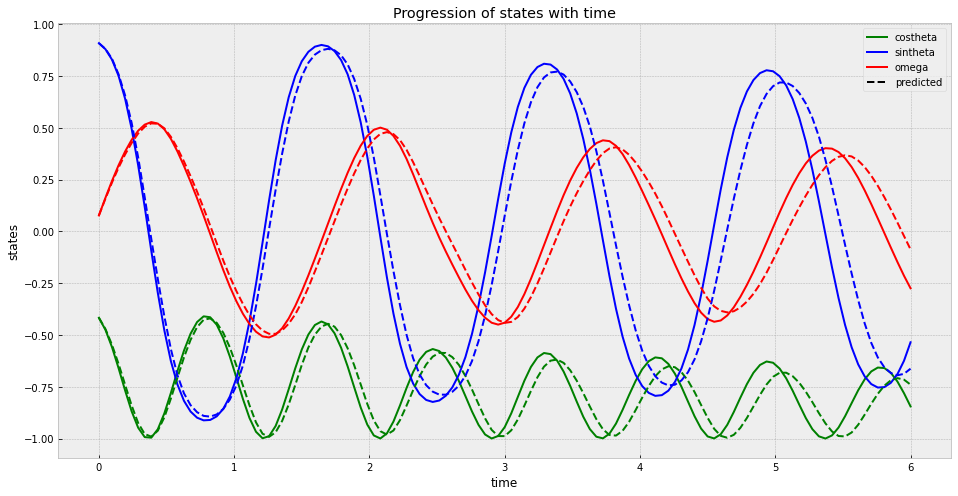

Total Loss 0.074281, 0.005471


In [0]:
ft_high = np.array([1, 1, SPEED_HIGH, ACTION_HIGH])

ft_low  = ft_high*-1
norm=normalizer([ft_low, ft_high], [-1,1])
validate_model(func, T)


# MPC with C-NODE


In [0]:

class PendulumDynamics(torch.nn.Module):
    def __init__(self, diff_eq, norm, dt):
        super(PendulumDynamics, self).__init__()
        self.diff_eq = diff_eq.cpu().double() #net
        self.norm =  torch.from_numpy(np.array([1., 1. , 8., 2.]))#norm
        self.dt = dt
    
    def forward(self, state, perturbed_action):
        # the state in here is in theta, dtheta and should be converted

        if state.dim() is 1 or perturbed_action.dim() is 1:
            state= state.view(1, -1)
            u = perturbed_action.view(1, -1)
        
        if perturbed_action.shape[1] > 1:
            u = perturbed_action[:, 0].view(-1, 1)

        u = torch.clamp(perturbed_action, ACTION_LOW, ACTION_HIGH).to(state)

        xu = torch.cat((state, u), dim = -1)
        xu_norm = xu/self.norm.to(xu) #self.norm.normalize(xu_conv)
        func = self.diff_eq.double().net
        
        next_state_norm = xu_norm[:,:nx] + func(xu_norm)*self.dt
        next_state = next_state_norm*self.norm[:-1].to(xu) #self.norm.denorm(next_xu_conv_norm)
         
        return next_state

In [0]:
class true_dynamics(torch.nn.Module):
      def forward(self, state, action):
          th = state[:, 0].view(-1, 1)
          thdot = state[:, 1].view(-1, 1)

          g = 10
          m = 1
          l = 1
          dt = 0.05

          u = action
          u = torch.clamp(u, -2, 2)

          newthdot = thdot + (-3 * g / (2 * l) * torch.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
          newth = th + newthdot * dt
          newthdot = torch.clamp(newthdot, -8, 8)

          state = torch.cat((angle_normalize(newth), newthdot), dim=1)
          return state

In [0]:
params = torch.tensor((10., 1., 1.))
dx = pendulum.PendulumDx(params, simple=True)

n_batch, T, mpc_T = 9, 100, 24
th = uniform(n_batch, (3/4)* np.pi, 1.25*np.pi)
thdot = uniform(n_batch, -1., 1.)
x_init = torch.stack((torch.cos(th), torch.sin(th), thdot), dim=1).double()
u_init = None
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

dynamics = PendulumDynamics(func,norm,dt)
plot = False

In [0]:
states_list = []

In [0]:
import warnings
x = x_init
u_init = None

# The cost terms for the swingup task can be alternatively obtained
# for this pendulum environment with:
# q, p = dx.get_true_obj()


goal_weights = torch.Tensor((1., 1., 0.1))
goal_state = torch.Tensor((1., 0. ,0.))
ctrl_penalty = 0.001
q = torch.cat((
    goal_weights,
    ctrl_penalty*torch.ones(dx.n_ctrl)
))
px = -torch.sqrt(goal_weights)*goal_state
p = torch.cat((px, torch.zeros(dx.n_ctrl)))
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
    mpc_T, n_batch, 1, 1
).double()
p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1).double()

t_dir = tempfile.mkdtemp()
print('Tmp dir: {}'.format(t_dir))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)
    for t in tqdm(range(100)):
        nominal_states, nominal_actions, nominal_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_init=u_init,
            u_lower=dx.lower, u_upper=dx.upper,
            lqr_iter=50,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=dx.linesearch_decay,
            max_linesearch_iter=dx.max_linesearch_iter,
            grad_method=GradMethods.AUTO_DIFF,
            eps=1e-2,
        )(x.double(), QuadCost(Q, p), dynamics)
        #print(nominal_objs[0])
        x_nop = util.get_traj(mpc_T, nominal_actions, x_init=x.double(), dynamics= dx)
        tt = torch.arange(mpc_T)*0.05
        #print(x_nop.shape, nominal_states.shape)
        if plot:
          plot_trajectories([to_np(x_nop)], [to_np(tt)], [to_np(nominal_states)])
        
        next_action = nominal_actions[0]
        u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl).double()), dim=0)
        u_init[-2] = u_init[-3]
        states_list.append(x)
        x = dx(x, next_action)

        n_row, n_col = 3, 3
        fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col,3*n_row))
        axs = axs.reshape(-1)
        for i in range(n_batch):
            dx.get_frame(x[i], ax=axs[i])
            axs[i].get_xaxis().set_visible(False)
            axs[i].get_yaxis().set_visible(False)
        fig.tight_layout()
        fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(t)))
        plt.close(fig)

  0%|          | 0/100 [00:00<?, ?it/s]

Tmp dir: /tmp/tmpn_66hzl6


100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


This plot involves the progression of actual states of the pendulum with time

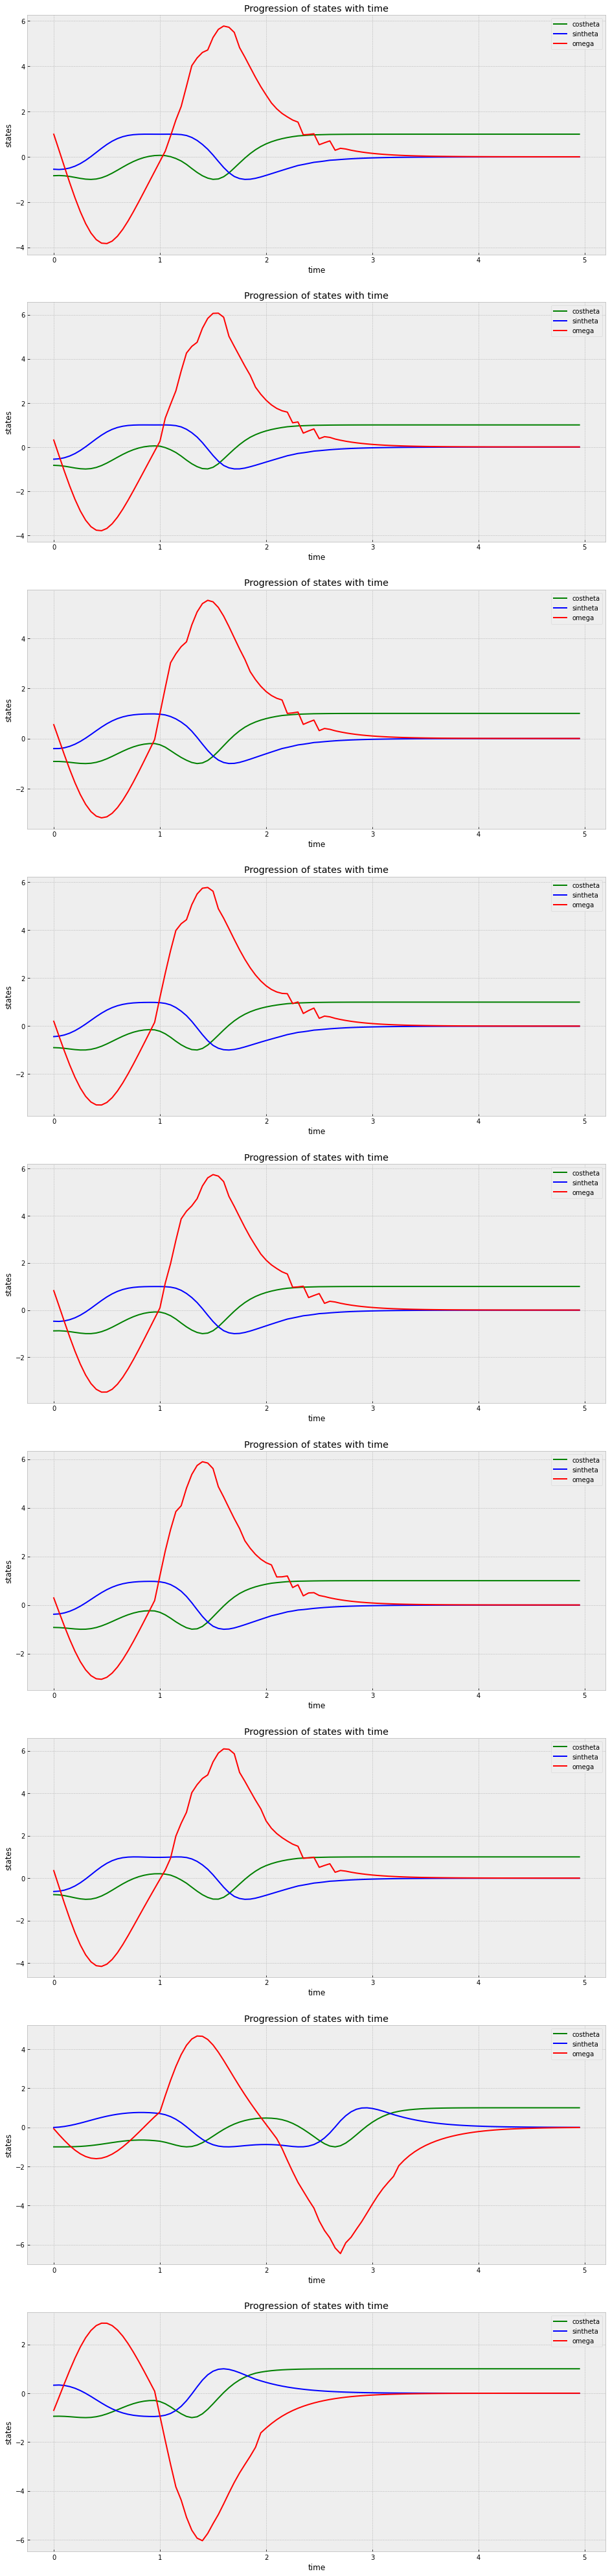

In [0]:
plot_trajectories([to_np(torch.stack(states_list))], [to_np(torch.arange(100)*0.05)], freq = 9)

In [0]:
vid_fname = 'pendulum-{}.mp4'.format('swingup')

if os.path.exists(vid_fname):
    os.remove(vid_fname)
    
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: pendulum-swingup.mp4


In [0]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))